# Decision Tree Implementation
* This code works only when:-
  * The features of dataset are discrete
  * The last column of dataset must be the label or class (output)
  * Missing data is not allowed

In [2]:
import pandas as pd
import numpy as np

In [37]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(np.append(iris.data,iris.target.reshape(-1,1),axis = 1),columns = ['sl','sw','pl','pw','y'])
df.head()

sl   sw   pl   pw    y
0  5.1  3.5  1.4  0.2  0.0
1  4.9  3.0  1.4  0.2  0.0
2  4.7  3.2  1.3  0.2  0.0
3  4.6  3.1  1.5  0.2  0.0
4  5.0  3.6  1.4  0.2  0.0

In [4]:
def label(val, *boundaries):
    if (val < boundaries[0]):       
        return 1                  
    elif (val < boundaries[1]):
        return 2
    elif (val < boundaries[2]):  #here i have converted continuous data to discrete values of 1 ,2 ,3, 4 in each column
                      #by <mean to be 2 , <(mean+min)/2 to be 1, <(mean+max)/2 to be 3 else to be 4                       
        
        return 3
    else:
        return 4

def toLabel(df, old_feature_name):
    second = df[old_feature_name].mean()
    minimum = df[old_feature_name].min()
    first = (minimum + second)/2
    maximum = df[old_feature_name].max()
    third = (maximum + second)/2
    return df[old_feature_name].apply(label, args= (first, second, third))

In [5]:
df['sl_labeled'] = toLabel(df, 'sl')   + #relabeling columns with discrete values and their header name
df['sw_labeled'] = toLabel(df, 'sw')
df['pl_labeled'] = toLabel(df, 'pl')
df['pw_labeled'] = toLabel(df, 'pw')
df.head()
c=1

In [6]:
df.drop(['sl', 'sw', 'pl', 'pw'], axis = 1, inplace = True)

In [7]:
col=['sl_labeled','sw_labeled','pl_labeled',"pw_labeled","y"]
df=df.reindex(columns=col)

In [8]:
set(df['sl_labeled'])

{1, 2, 3, 4}

In [9]:
df.head()

sl_labeled  sw_labeled  pl_labeled  pw_labeled    y
0           2           3           1           1  0.0
1           1           2           1           1  0.0
2           1           3           1           1  0.0
3           1           3           1           1  0.0
4           1           3           1           1  0.0

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0:4],df.iloc[:,4:], random_state = 1)
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.9736842105263158

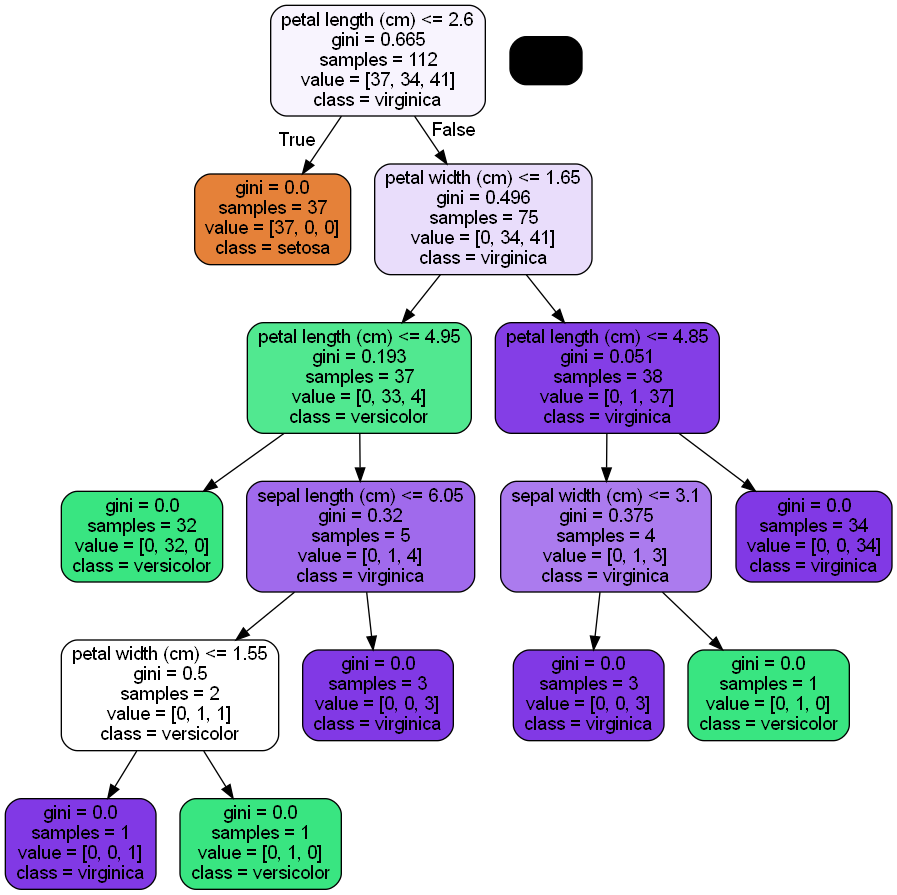

In [57]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data=export_graphviz(clf,out_file=None, feature_names=iris.feature_names,
                          class_names=iris.target_names,filled=True,rounded=True)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write("iris1.pdf")
Image(graph.create_png())

In [39]:
#converting feature columns and outputs in numpy array
unused_features = list(df.columns)
#unused_features.remove('y')
# xx = list(df.as_matrix(columns=unused_features))  ##numpy matrix of feature values

# y = np.array(df['y'])  ##numpy matrix of output values
xx = list(df[unused_features].to_numpy()) # numpy array of feature values
y = df['y'].to_numpy() # numpy array of output values

In [40]:
## Function for calculaing the entropy for any dataset whether it may be Parent or children
import math
def calEntropy(dataSet):
    entropy=0
    labelList=[example[-1] for example in dataSet]
    uniqueLabelSet=set(labelList) ## stores a particular value only once 
    labelCount={}
    for label in labelList:
        if label not in labelCount.keys():
            labelCount[label]=0
        labelCount[label]+=1
    for label in uniqueLabelSet:
        prob=float(labelCount[label])/len(dataSet)
        entropy-=prob*math.log(prob,2)
    return entropy

In [42]:
## It is just used for the split of dataset  according to a given feature
def splitDataSet(dataSet,feature,value):
    returnDataSet=[]
    for sample in dataSet:
        if sample[feature]==value:
            reducedSample=np.concatenate((sample[:feature],sample[feature+1:]))
            returnDataSet.append(reducedSample) #### Splitted dataset
    return returnDataSet

In [44]:
#This function decides the best feature to split upon using information gain
def bestFeatureToSplit(dataSet):
    featureNum=len(dataSet[0])-1 ## counts the total no. of features 
    
    bestFeature=-1
    bestInfoGain=0.0
    baseEntropy=calEntropy(dataSet) ## calculates entropy for each incoming dataset
    print('current Entropy is = %.16f' % baseEntropy)
    if baseEntropy==0:                   ## Special check for pure nodes
        print('Reached Leaf node')  ## and declaring them terminal node(leaf) thereafter
    ## Calculating  the informatin gain by first calculating the entropy for each children 
    ## and then subtracting their weighted avg. from the parent( baseEntropy)
    for feature in range(featureNum):
            newEntropy=0
            featureValue=[example[feature] for example in dataSet]
            uniqueFeatureValue=set(featureValue) ## stores a particular value only once 
            for value in uniqueFeatureValue:
                subDataSet=splitDataSet(dataSet,feature,value)
                prob=float(len(subDataSet))/len(dataSet)
                newEntropy+=prob*calEntropy(subDataSet)
            infoGain=baseEntropy-newEntropy
            if infoGain>bestInfoGain:
                bestInfoGain=infoGain
                bestFeature=feature
    ## Finding the split information by calculating sort of internal entropy within the feature for each feature value 
    splitinfo=0
    labelList=[example[bestFeature] for example in dataSet]
    uniqueLabelSet=set(labelList)
    labelCount={}
    for label in labelList:
        if label not in labelCount.keys():
            labelCount[label]=0
        labelCount[label]+=1
    for label in uniqueLabelSet:
        prob=float(labelCount[label])/len(dataSet)
        splitinfo-=prob*math.log(prob,2)   
        
    gain_ratio=bestInfoGain/splitinfo## Finding the gain ratio
    
    #### Printing which feature is currently getting used for split with all the parameters calculated for the split
    print('Splitting on feature %s with gain ratio %.16f'%(unused_features[bestFeature],gain_ratio))
    print("\n")
    return bestFeature

In [45]:
## function for calculating majority count for an impure node 
import operator
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount=sorted(classCount,reverse=True)
    return sortedClassCount
## final output for an impure node = sortedClassCount

In [47]:
def generateTree(dataSet,label,level,olddata):
    labelList_=[example[-1] for example in dataSet] ## label/output list for dataset 
    uniqueLabelSet_=set(labelList_) ## comprises of only uniquely identified labels 
    labelCount_={} ## Dictionary that keeps count(value) for each label(key)
    for label_ in labelList_:
        if label_ not in labelCount_.keys(): ## starts label count for already present label as well as 
            labelCount_[label_]=0            ## intializes count for the newly identified labels
        labelCount_[label_]+=1
        
        
   
    ##### Printing the level number at which evaluation takes place ####### 
    if dataSet!=olddata:
        level+=1
        olddata=dataSet
        print('Level ',level)
    else:
        print('Level ',level)
    ###### Printing Over #######
    
    ##### printing the count of labels corresponding to each parent or child in present dataset #####           
    for i in labelCount_:    
        print('Count of %s  = %d'%(i,labelCount_[i]))
        if (calEntropy(dataSet))==0: ## Special check whether or not the leaf node reached
            print('Current Entropy is: %f'%calEntropy(dataSet))
            print('Reached leaf Node',end='\n\n')        
    ######## Printing over ###########
    
    
    labelList=[example[-1] for example in dataSet] # creates list of the labels in present dataset
    
    ###### TERMINATION CONDITIONS for Recursion #####
    if labelList.count(labelList[0])==len(labelList):  ## condition for checking if or not node is pure 
        return labelList[0] 
    
    if len(dataSet[0])==1:            #### If the node isn't pure then we vote for the majority labels present in the dataset 
        return majorityCnt(labelList)
    #### END of TERMINATION CONDITIONS #####
    
    bestFeature=bestFeatureToSplit(dataSet) ## calling the bestFeatureToSplit() to know the best feature to split upon
    bestFeatureLabel=label[bestFeature]
    DecisionTree={bestFeatureLabel:{}} #### Creating a nested dictionary containing our decision tree 
    ## For above dictionary :-
    ## keys =features on which split has taken place at each step
    ## Value=the corresponding output if the current node is a leaf otherwise another dictionary for next feature split
    del(label[bestFeature]) #### Deleting the feature upon which split has already taken place
    
    ##### Starting the actual decision making by using best feature split ######
    featureValues=[example[bestFeature] for example in dataSet]
    uniqueFeatureValues=set(featureValues) ## stores a particular value only once 
    #print(uniqueFeatureValues)
    for value in uniqueFeatureValues:
        subDataSet=splitDataSet(dataSet,bestFeature,value)
        subLabel=label[:]
        DecisionTree[bestFeatureLabel][value]=generateTree(subDataSet,subLabel,level,olddata)##Recursion call for reduced dataset after split  
    return DecisionTree
DecisionTree=generateTree(xx,unused_features,0,xx)
print()
print('# Printing decision tree in form of nested dictionary retured by generateTree() function :',end='\n\n')
print(DecisionTree)

Level  0
Count of 0.0  = 50
Count of 1.0  = 50
Count of 2.0  = 50
current Entropy is = 1.5849625007211561
Splitting on feature pw with gain ratio 0.2872770737032454


Level  1
Count of 0.0  = 4
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 13
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 7
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 7
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 13
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 1
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 2
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 1
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 0.0  = 2
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 1.0  = 5
Current Entropy is: 0.000000
Reached leaf Node

Level  1
Count of 1.0  = 7
Count of 2.0  = 1
current Entropy is = 0.5435644431995

AttributeError: featureNames